# Оптимизация портфеля в модели Хестона

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

In [15]:
# Parameters
# simulation dependent
S0 = 100.0             # asset price
T = 1.0                # time in years
r = 0.02               # risk-free rate
N = 252                # number of time steps in simulation
M = 100               # number of simulations

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility

In [16]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations
    
    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    
    return S, v

In [19]:
rho_p = 0.98
S_p,v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)

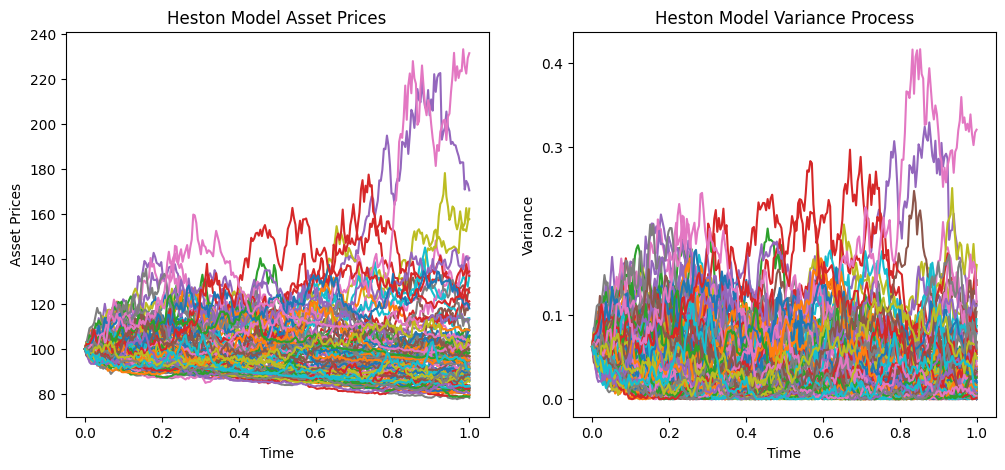

In [20]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time,S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,v_p)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')

plt.show()

/home/eugene/miniconda3/lib/python3.12/site-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


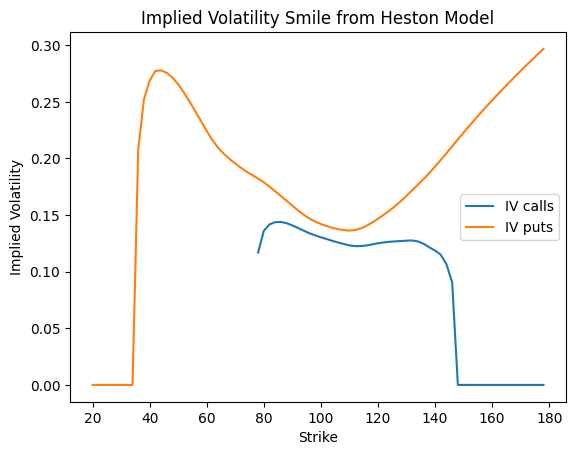

In [22]:
rho = -0.7
S,v = heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M)

# Set strikes and complete MC option price for different strikes
K = np.arange(20,180,2)

puts = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S,0)) for k in K])
calls = np.array([np.exp(-r*T)*np.mean(np.maximum(S-k,0)) for k in K])

put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')

plt.plot(K, call_ivs, label=r'IV calls')
plt.plot(K, put_ivs, label=r'IV puts')

plt.ylabel('Implied Volatility')
plt.xlabel('Strike')

plt.title('Implied Volatility Smile from Heston Model')
plt.legend()
plt.show()

In [38]:
def heston_portfolio_optimization(S, v, r, gamma, mu):
    """
    Оптимизация портфеля для модели Хестона с ежедневной ребалансировкой
    
    Параметры:
    S - массив цен активов (размер: (n_steps+1, n_paths))
    v - массив волатильностей (размер: (n_steps+1, n_paths))
    r - безрисковая ставка (годовая)
    gamma - коэффициент неприятия риска
    mu - ожидаемая доходность рискового актива
    
    Возвращает:
    weights - массив весов в рисковом активе
    wealth - массив богатства портфеля
    """
    n_steps, n_paths = S.shape
    dt = T / (n_steps - 1)
    
    # Инициализация массивов
    weights = np.zeros((n_steps, n_paths))
    wealth = np.ones((n_steps, n_paths)) * 100  # Начальное богатство = 100
    
    for t in range(n_steps - 1):
        # Расчет логарифмической доходности
        returns = (S[t+1] - S[t]) / S[t]
        
        # Оптимальный вес в рисковом активе (формула из теории)
        w = ((mu - r) + 0.5 * v[t]) / (gamma * v[t])
        
        # Ограничение весов (0-100%)
        w = np.clip(w, 0, 1)
        weights[t] = w
        
        # Обновление богатства портфеля
        portfolio_return = w * returns + (1 - w) * (r * dt)
        wealth[t+1] = wealth[t] * (1 + portfolio_return)
    
    return weights, wealth

# Оптимизация портфеля в модели GARCH(1, 1)

In [24]:
from random import gauss
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_pacf

#### Сгенерируем данные для дальнейшего обучения модели GARCH

In [48]:
# Создадим датасет
n = 252
omega = 0.5

alpha_1 = 0.1
alpha_2 = 0.2

beta_1 = 0.3
beta_2 = 0.4

test_size = int(n*0.25)

series = [gauss(0,1), gauss(0,1)]
vols = [1, 1]

for _ in range(n):
    new_vol = np.sqrt(omega + alpha_1*series[-1]**2 + alpha_2*series[-2]**2 + beta_1*vols[-1]**2 + beta_2*vols[-2]**2)
    new_val = gauss(0,1) * new_vol
    
    vols.append(new_vol)
    series.append(new_val)

Text(0.5, 1.0, 'Симулированные данные для модели GARCH(1, 1)')

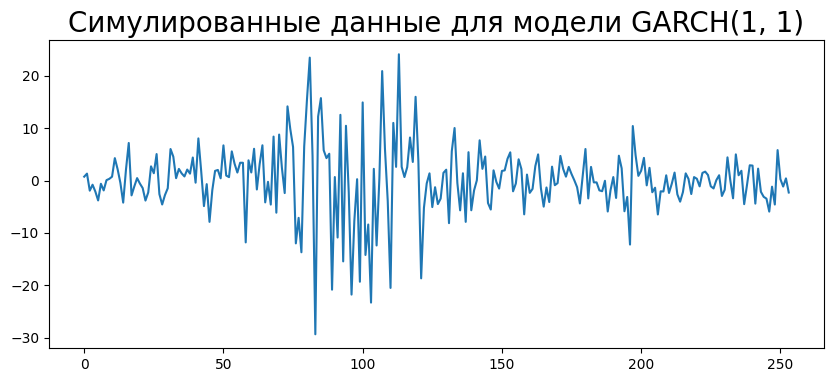

In [49]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.title('Симулированные данные для модели GARCH(1, 1)', fontsize=20)

Text(0.5, 1.0, 'Волатильности симулированных данных')

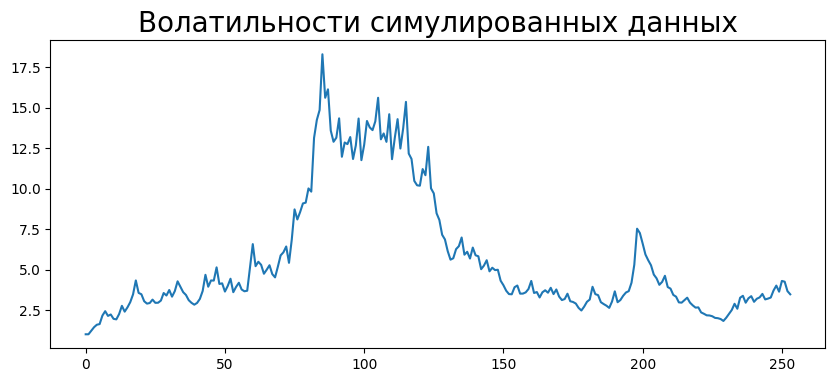

In [50]:
plt.figure(figsize=(10,4))
plt.plot(vols)
plt.title('Волатильности симулированных данных', fontsize=20)

#### Построим график PACF (частичная автокорреляция)

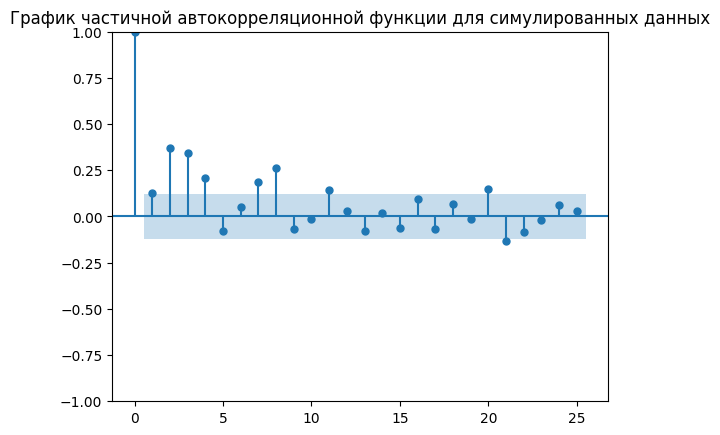

In [51]:
plot_pacf(np.array(series)**2)
plt.title('График частичной автокорреляционной функции для симулированных данных')
plt.show()

#### Обучим модель GARCH(1, 1)

In [52]:
train, test = series[:-test_size], series[-test_size:]

In [53]:
model = arch_model(train, p=1, q=1)

In [54]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 648.2241869764443
Iteration:      2,   Func. Count:     12,   Neg. LLF: 39698035.53553663
Iteration:      3,   Func. Count:     18,   Neg. LLF: 5907.978867975004
Iteration:      4,   Func. Count:     24,   Neg. LLF: 595.5202276242479
Iteration:      5,   Func. Count:     30,   Neg. LLF: 594.045326720928
Iteration:      6,   Func. Count:     36,   Neg. LLF: 593.7621737551883
Iteration:      7,   Func. Count:     42,   Neg. LLF: 593.7214490895251
Iteration:      8,   Func. Count:     47,   Neg. LLF: 593.7181635901957
Iteration:      9,   Func. Count:     52,   Neg. LLF: 593.7181557126348
Iteration:     10,   Func. Count:     56,   Neg. LLF: 593.7181557127853
Optimization terminated successfully    (Exit mode 0)
            Current function value: 593.7181557126348
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10


In [55]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -593.718
Distribution:                  Normal   AIC:                           1195.44
Method:            Maximum Likelihood   BIC:                           1208.45
                                        No. Observations:                  191
Date:                Sun, Sep 14 2025   Df Residuals:                      190
Time:                        18:02:59   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1093      0.322      0.339      0.734 [ -0.522,  0.741]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.6321      0.338      1.871  6.135e-02 [-3.006e-02,  1.294]
alpha[1]       0.1479  3.226e-02      4.585  4.529e-06  [8.471e-02,  0.211]
beta[1]        0.8402  2.178e-02     38.577      0.000    [  0.798,  0.883]
===========================================================================

Covariance estimator: robust
"""

#### Сделаем предсказания волатильности для тестовой выборки скользящим окном

In [58]:
rolling_predictions = []
for i in range(test_size):
    train = series[:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

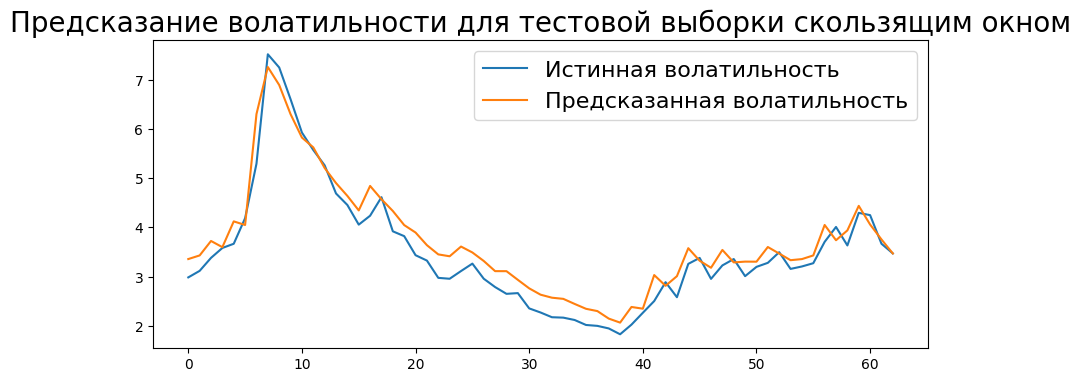

In [59]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:])
preds, = plt.plot(rolling_predictions)
plt.title('Предсказание волатильности для тестовой выборки скользящим окном', fontsize=20)
plt.legend(['Истинная волатильность', 'Предсказанная волатильность'], fontsize=16)

In [64]:
def garch_portfolio_optimization(returns, r, gamma, mu, p=1, q=1):
    """
    Оптимизация портфеля для модели GARCH(1,1) с ежедневной ребалансировкой
    
    Параметры: 
    returns - массив исторических доходностей
    r - безрисковая ставка (годовая)
    gamma - коэффициент неприятия риска
    mu - ожидаемая доходность рискового актива
    p, q - параметры GARCH модели
    
    Возвращает:
    weights - массив весов в рисковом активе
    wealth - массив богатства портфеля
    """
    n = len(returns)
    test_size = int(n * 0.25)  # 25% данных для тестирования
    train_size = n - test_size
    
    # Инициализация массивов
    weights = np.zeros(n)
    wealth = np.ones(n) * 100
    
    # Скользящее окно прогнозирования
    for i in range(train_size, n):
        # Обучаем модель на данных до текущего момента
        train = returns[:i]
        model = arch_model(train, p=p, q=q)
        model_fit = model.fit(disp='off')
        
        # Прогноз волатильности на следующий период
        forecast = model_fit.forecast(horizon=1)
        sigma2 = forecast.variance.values[-1, 0]
        
        # Оптимальный вес в рисковом активе
        w = ((mu - r) + 0.5 * sigma2) / (gamma * sigma2)
        
        # Ограничение весов (0-100%)
        w = np.clip(w, 0, 1)
        weights[i] = w
        
        # Обновление богатства портфеля
        portfolio_return = w * returns[i] + (1 - w) * (r / 252)
        wealth[i] = wealth[i-1] * (1 + portfolio_return)
    
    return weights, wealth

# Сравнение стратегий

Реализуем функцию для сравнения эффективности двух стратегий по критерию ожидаемой полезности

In [68]:
def compare_strategies(S_heston, v_heston, returns_garch, r, gamma, mu):
    """Сравнение стратегий для Heston и GARCH моделей"""
    # Оптимизация для Heston
    weights_heston, wealth_heston = heston_portfolio_optimization(
        S_heston, v_heston, r, gamma, mu
    )
    
    # Оптимизация для GARCH
    weights_garch, wealth_garch = garch_portfolio_optimization(
        returns_garch, r, gamma, mu
    )
    
    # Расчет полезности (CRRA)
    def crra_utility(wealth, gamma):
        if gamma == 1:
            return np.log(wealth)
        return wealth**(1 - gamma) / (1 - gamma)
    
    # Усредненная полезность для Heston
    utility_heston = np.mean(crra_utility(wealth_heston[-1], gamma))
    
    # Полезность для GARCH (одна траектория)
    utility_garch = crra_utility(wealth_garch[-1], gamma)
    
    # Визуализация результатов
    plt.figure(figsize=(14, 10))
    
    # График богатства
    plt.subplot(221)
    plt.plot(wealth_heston.mean(axis=1), label='Heston (mean)')
    plt.plot(wealth_heston[:, :5], alpha=0.3)
    plt.title('Богатство портфеля (Heston)')
    plt.xlabel('Дни')
    plt.ylabel('Богатство')
    plt.grid(True)
    
    plt.subplot(222)
    plt.plot(wealth_garch)
    plt.title('Богатство портфеля (GARCH)')
    plt.xlabel('Дни')
    plt.ylabel('Богатство')
    plt.grid(True)
    
    # График весов
    plt.subplot(223)
    plt.plot(weights_heston.mean(axis=1), label='Mean weight')
    plt.title('Доля в рисковом активе (Heston)')
    plt.xlabel('Дни')
    plt.ylabel('Доля')
    plt.grid(True)
    
    plt.subplot(224)
    plt.plot(weights_garch)
    plt.title('Доля в рисковом активе (GARCH)')
    plt.xlabel('Дни')
    plt.ylabel('Доля')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'weights_heston': weights_heston,
        'wealth_heston': wealth_heston,
        'weights_garch': weights_garch,
        'wealth_garch': wealth_garch,
        'utility_heston': utility_heston,
        'utility_garch': utility_garch
    }

In [69]:
# Параметры для Heston модели
S0 = 100.0
T = 1.0
r = 0.02
N = 252
M = 1000
kappa = 3
theta = 0.20**2
v0 = 0.25**2
rho = -0.7
sigma = 0.6

# Генерация данных для Heston
S_heston, v_heston = heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M)

# Параметры для GARCH модели
returns_garch = series  # Здесь должны быть исторические данные доходностей

# Параметры оптимизации
gamma = 4  # Коэффициент неприятия риска
mu = 0.08  # Ожидаемая годовая доходность

/tmp/ipykernel_15641/1495680783.py:28: RuntimeWarning: divide by zero encountered in divide
  w = ((mu - r) + 0.5 * v[t]) / (gamma * v[t])


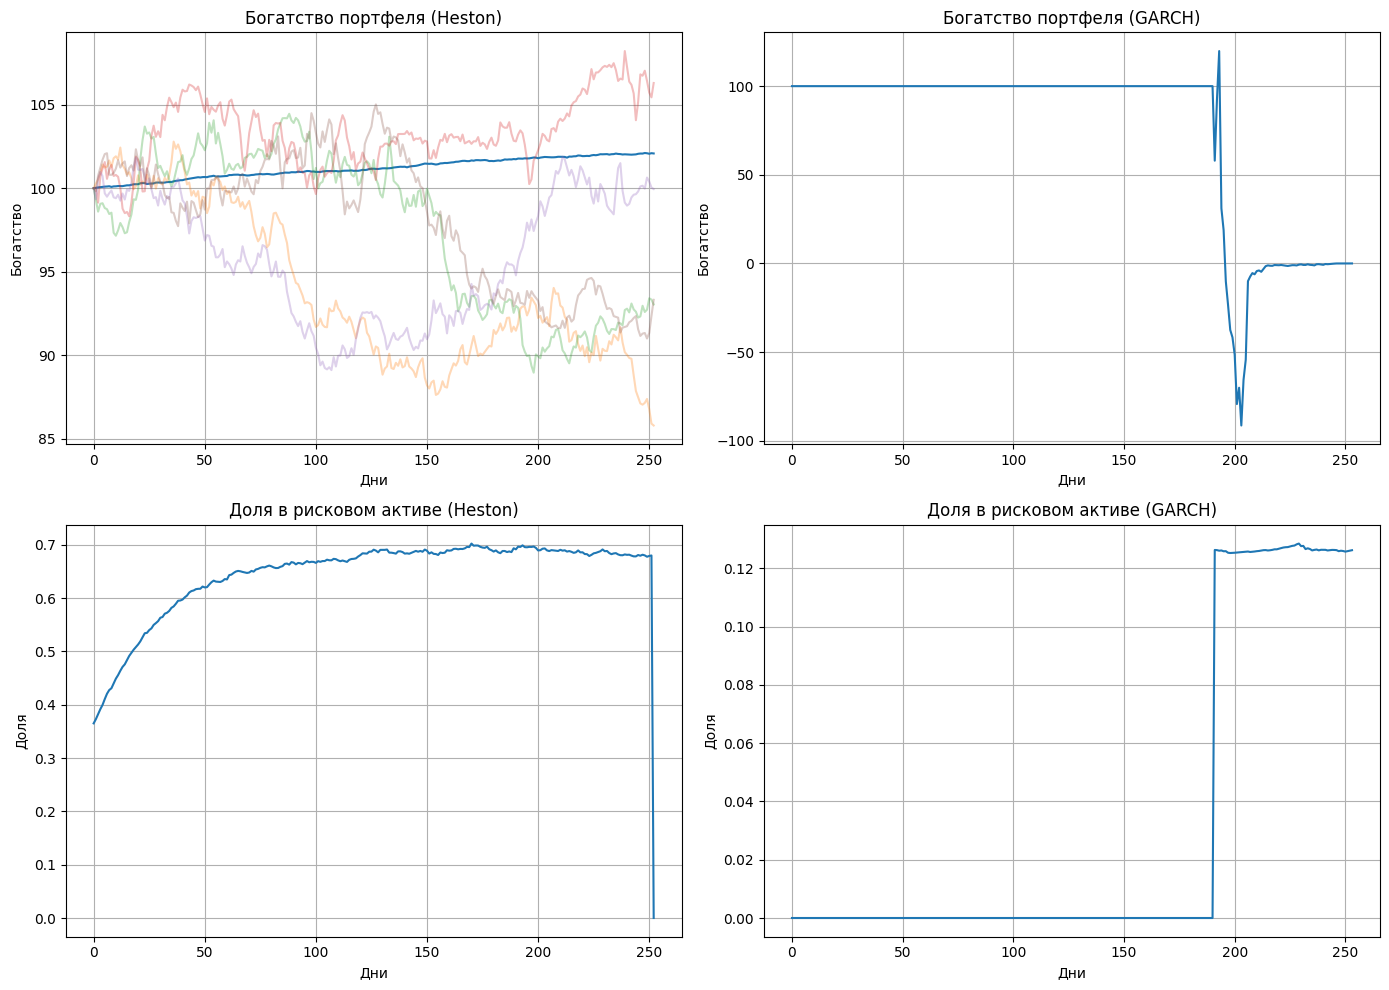

In [70]:
# Сравнение стратегий
results = compare_strategies(S_heston, v_heston, returns_garch, r, gamma, mu)